In [1]:
# -------- Code Outline -------- #
# Code plots phase lag - m poincare plots
# From the extracted peaks and then also plots
# Colour coded density plots which could potentially
# Be input into a CNN and identified. It also then tries
# To fit an ellipse to the poincare plot as well as calculate
# Standard deviations for the data as well as complex correlation
# Measure. Three histograms are then plotted representing short/long
# And overall heart rate variability

import numpy as np
import numpy.linalg as m
import matplotlib.pyplot as plt
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import pickle
import math

In [2]:
# -------- Loader -------- #
# Load in the peak we got from the Pan-Tompkins algorithm

# Load in the peaks
with open('Peak Arrays From Pickus/4048_Pickus_R_Peaks.pkl', 'rb') as f:
    Data = pickle.load(f)

In [3]:
# -------- Find RR Distances -------- #
# Find the distances between successive peaks

def find_RR_distances(Data):
    
    # Need arrays for RR(n)
    RR_n = []
    
    # Loop over all the peaks and find corresponding distances
    for i,peak in enumerate(Data):
    
        # Append the distance between consecutive peaks until you reach the final peak
        # Append the index of the RR interval
        if (i != 0):
        
            # Add in a manual check to try and reduce number of dodgy data points
            # Ie no excessively large/small RR interval lengths
            # Likely won't need this once the peak finding algorithm is better
        
            length = (Data[i] - Data[i - 1])
        
            if ((length >= 50) and (length <= 400)):
        
                RR_n.append(length)
            
    return RR_n

In [4]:
# -------- Adjust For Lag-m -------- #

# Now we need to adjust the array depending upon the lag
# Ie if we are plotting RR(n) against RR(n+m)
# Then we need to shift the RR(n) matrix by one ie.
# Delete the first element and re-index

# First get the matrix of lag-0
RR_n = find_RR_distances(Data)

# Now adjust for lag

lag = 1

# Copy the RR_n matrix then delete the first m elements
# Remove the last m elements from the RR_n matrix
RR_nm = RR_n[:]
del RR_nm[0:(lag)]
del RR_n[-lag:]

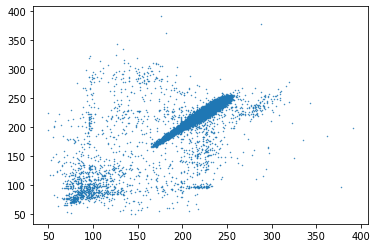

In [5]:
# -------- Standard Plotter -------- #
# Plot the basic scatter graph for the data

# Now the arrays are the same size and can be plotted

plt.scatter(RR_n, RR_nm, s=0.2)

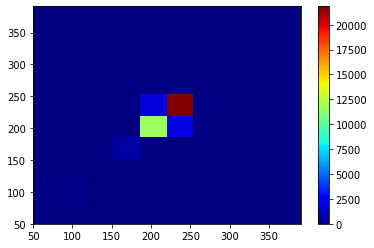

In [6]:
# -------- Colour Coded Graph -------- #
# Now we need some form of colour scale to represent 
# Density of points ready to be input to the CNN

plt.hist2d(RR_n, RR_nm, cmap=plt.cm.jet)
plt.colorbar()

In [7]:
# -------- Distance and Standard Deviation Calculation -------- #
# Need to try and fit an ellipse to the poincare plot in order
# For us to calculate different statistical values from the data
# Could also then potentially look at different histogram methods
# The Ellipse has to be general to fit any lag-m plot

# In order to fit the ellipse we need to find distances from the 
# Major and minor axes for every point in the plot

# Distances to minor axis: ((RRi - RRi+1) / sqrt(2))
# Distances to major axis: ((RRi + RRi+1 - 2 <RR>) / sqrt(2)) <RR> Mean value of RR intervals

# Create arrays for data as well as calculate mean RR interval
RR_interval_mean = np.mean(RR_n)
minor_axis_distances = []
major_axis_distances = []

for i in range(len(RR_n)):
    
    # Find all the distances and append them
    minor_i = ((RR_n[i] - RR_nm[i]) / np.sqrt(2))
    major_i = ((RR_n[i] + RR_nm[i] - (2 * RR_interval_mean)) / np.sqrt(2))
    
    minor_axis_distances.append(minor_i)
    major_axis_distances.append(major_i)
    
# Now that we have this data we can find the standard deviations

# Standard deviations rely on the square of the distances
# First convert to numpy arrays

minor_distances = np.array(minor_axis_distances)
major_distances = np.array(major_axis_distances)

minor_axis_squared = minor_distances ** 2
major_axis_squared = major_distances ** 2

SD1 = np.std(minor_axis_squared)
SD2 = np.std(major_axis_squared)

center =  (166.64012707606497, 180.89703799155035)
angle of rotation =  0.8150760895992873
axes =  (76.97620424627098, 45.71979112726353)


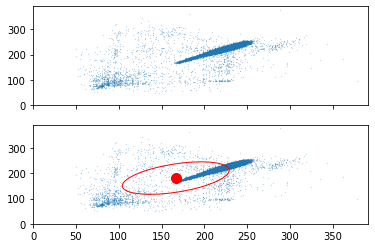

In [8]:
# -------- Ellipse Fitter -------- #
# Here we implement code to try and fit ellipse to the scatter plot
# Note this isn't effective for patients with heartbeats that aren't
# Exhibiting normal sinus rhythm. Might be better off trying to fit an
# Outline to the overall scatter plot for these then we will have different shapes
# Showing different arrhythmias and these might be better for use in a CNN etc.
# IE AF patients will have some sort of fan shape pattern

points = np.array((RR_n,RR_nm)).T

RR_n = np.array(RR_n)
RR_nm = np.array(RR_nm)

ell = EllipseModel()
ell.estimate(points)

xc, yc, a, b, theta = ell.params

print("center = ",  (xc, yc))
print("angle of rotation = ",  theta)
print("axes = ", (a,b))

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
axs[0].scatter(RR_n,RR_nm, s = 0.01)

axs[1].scatter(RR_n, RR_nm, s = 0.01)
axs[1].scatter(xc, yc, color='red', s=100)
axs[1].set_xlim(0, RR_n.max())
axs[1].set_ylim(0, RR_nm.max())

ell_patch = Ellipse((xc, yc), 2*a, 2*b, theta*180/np.pi, edgecolor='red', facecolor='none')

axs[1].add_patch(ell_patch)
plt.show()

In [9]:
# -------- Non-Linear Variables Calculation -------- #
# Now we can calculate some linear HRV indices

# SD1 = ((1/ sqrt(2)) * SDSD) where SDSD is standard deviation of the RR intervals
# SD2 = sqrt((2 * (SDRR ** 2)) - (0.5 * (SDSD ** 2))) where SDRR is the standard
# Deviation of successive differences of the RR interval

SDSD = (SD1 * np.sqrt(2))

SDRR = np.sqrt((0.5 * ((SD2 ** 2) + (0.5*(SDSD ** 2)))))

# Now we can calculate the complex correlation measure

Cn = (np.pi * SD1 * SD2)

# Loop over all the consecutive points and find areas of triangles of 3 consecutive points
# Create a list to save all the determinants (areas)
areas = []

for i in range(math.floor(len(RR_n) / 3)):
    matrix = np.matrix([[RR_n[i], RR_nm[i], 1], [RR_n[i+1], RR_nm[i+1], 1], [RR_n[i+2], RR_nm[i+2], 1]])
                        
    area = m.det(matrix)
    areas.append((0.5 * area))

CCM = ((1 / (Cn * (len(RR_n) - 2))) * sum(areas))
print(CCM)

-4.011876744015313e-06


(array([4.000e+00, 6.000e+00, 5.000e+00, 5.000e+00, 1.200e+01, 2.200e+01,
        3.200e+01, 6.600e+01, 6.400e+01, 8.500e+01, 7.200e+01, 6.100e+01,
        7.700e+01, 9.100e+01, 9.300e+01, 4.300e+01, 3.100e+01, 4.800e+01,
        2.600e+01, 4.500e+01, 3.500e+01, 3.900e+01, 3.000e+01, 3.100e+01,
        3.900e+01, 2.000e+01, 3.200e+01, 1.300e+01, 1.400e+01, 3.500e+01,
        2.000e+01, 2.500e+01, 2.000e+01, 1.800e+01, 5.000e+01, 8.600e+01,
        1.150e+02, 1.680e+02, 2.110e+02, 2.370e+02, 1.830e+02, 3.180e+02,
        2.720e+02, 6.090e+02, 7.370e+02, 1.000e+03, 2.217e+03, 2.064e+03,
        3.131e+03, 3.244e+03, 4.138e+03, 6.032e+03, 3.999e+03, 4.057e+03,
        1.961e+03, 1.398e+03, 1.314e+03, 5.610e+02, 3.360e+02, 8.900e+01,
        4.500e+01, 1.800e+01, 1.000e+01, 1.800e+01, 6.000e+00, 9.000e+00,
        9.000e+00, 1.400e+01, 2.100e+01, 1.200e+01, 1.300e+01, 8.000e+00,
        7.000e+00, 7.000e+00, 4.000e+00, 5.000e+00, 4.000e+00, 1.000e+00,
        3.000e+00, 0.000e+00, 2.000e+0

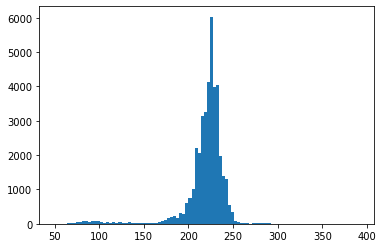

In [10]:
# Now plot histograms to represent overall/short/long term
# Heart rate variability

# Overall
plt.hist(RR_n, bins = 100)

(array([2.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00,
        1.0000e+00, 5.0000e+00, 5.0000e+00, 7.0000e+00, 7.0000e+00,
        6.0000e+00, 6.0000e+00, 6.0000e+00, 8.0000e+00, 8.0000e+00,
        7.0000e+00, 1.4000e+01, 1.7000e+01, 1.8000e+01, 1.3000e+01,
        1.8000e+01, 2.1000e+01, 1.3000e+01, 2.4000e+01, 9.0000e+00,
        2.3000e+01, 1.6000e+01, 1.4000e+01, 2.2000e+01, 2.2000e+01,
        1.3000e+01, 1.9000e+01, 2.0000e+01, 2.5000e+01, 2.4000e+01,
        2.4000e+01, 2.8000e+01, 3.4000e+01, 4.3000e+01, 5.4000e+01,
        6.1000e+01, 5.9000e+01, 8.2500e+02, 8.9650e+03, 1.8665e+04,
        8.9060e+03, 9.9500e+02, 1.2300e+02, 7.9000e+01, 5.2000e+01,
        4.9000e+01, 4.3000e+01, 6.2000e+01, 5.9000e+01, 5.2000e+01,
        5.0000e+01, 3.9000e+01, 4.1000e+01, 2.9000e+01, 2.5000e+01,
        2.6000e+01, 1.8000e+01, 2.0000e+01, 2.9000e+01, 1.7000e+01,
        8.0000e+00, 1.6000e+01, 1.4000e+01, 2.4000e+01, 1.7000e+01,
        2.1000e+01, 4.0000e+00, 2.0000e+00, 1.00

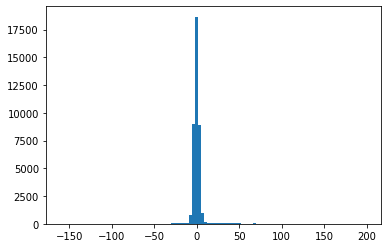

In [11]:
# Short term
plt.hist(minor_distances, bins = 100)

(array([3.000e+00, 2.000e+00, 7.000e+00, 1.100e+01, 3.200e+01, 4.100e+01,
        3.400e+01, 3.500e+01, 6.900e+01, 5.400e+01, 5.600e+01, 7.800e+01,
        4.900e+01, 6.200e+01, 5.300e+01, 3.800e+01, 5.700e+01, 3.100e+01,
        4.000e+01, 3.600e+01, 1.700e+01, 2.500e+01, 1.700e+01, 3.100e+01,
        2.400e+01, 1.600e+01, 2.800e+01, 1.400e+01, 2.100e+01, 1.800e+01,
        2.100e+01, 2.400e+01, 2.000e+01, 3.600e+01, 2.100e+01, 3.600e+01,
        2.500e+01, 2.600e+01, 2.800e+01, 6.400e+01, 8.900e+01, 7.000e+01,
        1.500e+02, 1.910e+02, 1.960e+02, 1.630e+02, 1.620e+02, 2.640e+02,
        2.040e+02, 3.290e+02, 3.750e+02, 5.870e+02, 9.170e+02, 1.130e+03,
        1.909e+03, 1.691e+03, 1.794e+03, 2.884e+03, 3.064e+03, 4.458e+03,
        3.972e+03, 4.134e+03, 2.774e+03, 2.048e+03, 1.798e+03, 1.101e+03,
        1.044e+03, 5.350e+02, 3.130e+02, 1.680e+02, 6.600e+01, 3.800e+01,
        1.600e+01, 1.300e+01, 1.400e+01, 4.000e+00, 7.000e+00, 7.000e+00,
        8.000e+00, 5.000e+00, 5.000e+0

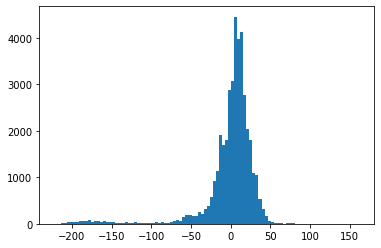

In [12]:
# Long term
plt.hist(major_distances, bins = 100)